In [1]:
# -*- coding: utf-8 -*-
"""Untitled1.ipynb

Automatically generated by Colaboratory.

"""


'Untitled1.ipynb\n\nAutomatically generated by Colaboratory.\n\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras
!pip install livelossplot

In [4]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

In [5]:

#training_data_dir ="/content/drive/.../train" # 
#validation_data_dir = "/content/drive/.../test" #
training_data_dir ="/content/drive/MyDrive/498-499/code/test16/train" # 
validation_data_dir = "/content/drive/MyDrive/498-499/code/test16/test" #


In [6]:

# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =30
BATCH_SIZE =2
TEST_SIZE = 2
learning = 0.00001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)


In [7]:

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "VGG19.h5"

----
# **VGG19**
----

In [8]:
#VGG19 - Pretrained

import tensorflow as tf

# %matplotlib inline

base_model=tf.keras.applications.VGG19(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy',metrics=['accuracy'])

import warnings
warnings.filterwarnings("ignore")

model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [9]:
#preprocessing preparing (assigning the parameter)
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)


In [10]:
#preprocessing and resize 
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)

Found 3728 images belonging to 2 classes.
Found 930 images belonging to 2 classes.


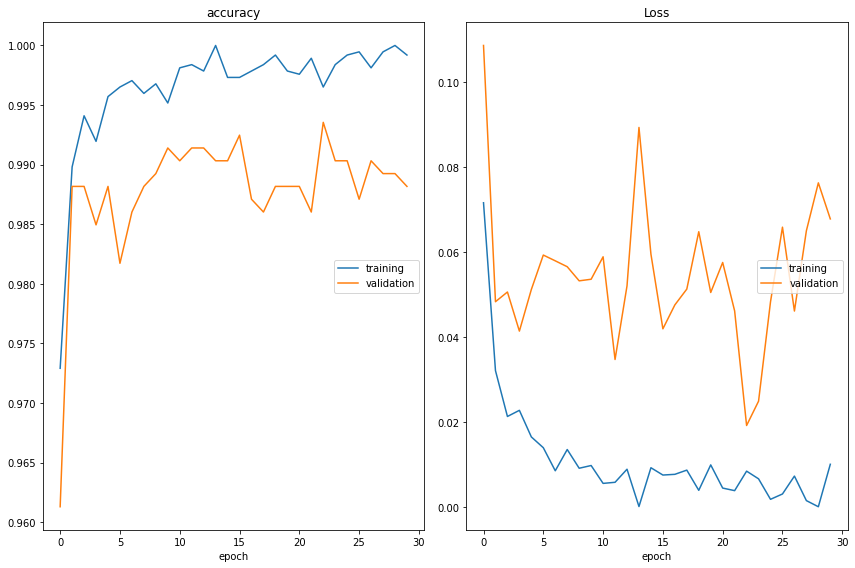

accuracy
	training         	 (min:    0.973, max:    1.000, cur:    0.999)
	validation       	 (min:    0.961, max:    0.994, cur:    0.988)
Loss
	training         	 (min:    0.000, max:    0.072, cur:    0.010)
	validation       	 (min:    0.019, max:    0.109, cur:    0.068)


In [11]:
# Training
import warnings
warnings.filterwarnings("ignore")

# Training
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)



model.save(MODEL_FILE)


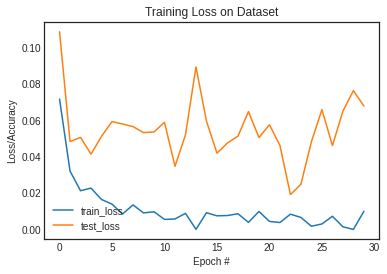

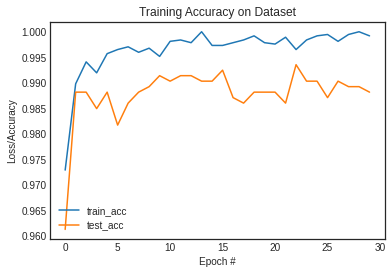

In [12]:
#ploting
N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Found 930 images belonging to 2 classes.
Confusion Matrix


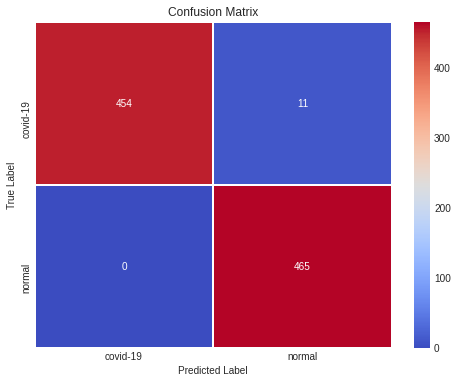

[[454  11]
 [  0 465]]
Classification Report
              precision    recall  f1-score   support

    covid-19       1.00      0.98      0.99       465
      normal       0.98      1.00      0.99       465

    accuracy                           0.99       930
   macro avg       0.99      0.99      0.99       930
weighted avg       0.99      0.99      0.99       930



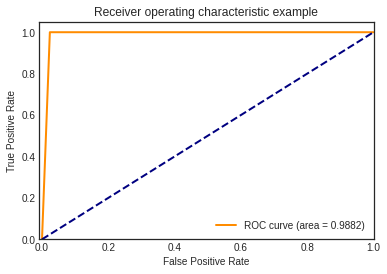

In [13]:
#evaluation result
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)    

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [14]:
#Model Prediction
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

im = load_img('/content/drive/MyDrive/498-499/code/test11/dataset-1200 image/test/covid/COVID (1000).png', target_size=(224, 224))
im = img_to_array(im)
im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
predict_image=(model.predict(im))
label="non"
acc=0.0
if predict_image[0][0] > predict_image[0][1]:
    label="COVID"
    acc=str(int(predict_image[0][0]*100))+"%"#percentage
else :
    label="NORMAL"
    acc=str(int(predict_image[0][1]*100))+"%"#percentage
predect=[label,acc]
print(predect)

['COVID', '100%']
